## You're here! 
Welcome to your first competition in the [ITI's AI Pro training program](https://ai.iti.gov.eg/epita/ai-engineer/)! We hope you enjoy and learn as much as we did prepairing this competition.


## Introduction

In the competition, it's required to predict the `Severity` of a car crash given info about the crash, e.g., location.

This is the getting started notebook. Things are kept simple so that it's easier to understand the steps and modify it.

Feel free to `Fork` this notebook and share it with your modifications **OR** use it to create your submissions.

### Prerequisites
You should know how to use python and a little bit of Machine Learning. You can apply the techniques you learned in the training program and submit the new solutions! 

### Checklist
You can participate in this competition the way you perefer. However, I recommend following these steps if this is your first time joining a competition on Kaggle.

* Fork this notebook and run the cells in order.
* Submit this solution.
* Make changes to the data processing step as you see fit.
* Submit the new solutions.

*You can submit up to 5 submissions per day. You can select only one of the submission you make to be considered in the final ranking.*


Don't hesitate to leave a comment or contact me if you have any question!

## Import the libraries

We'll use `pandas` to load and manipulate the data. Other libraries will be imported in the relevant sections.

In [1]:
import pandas as pd
import numpy as np
import os

dataset_path = '/kaggle/input/car-crashes-severity-prediction/'
df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
# print("The shape of the dataset is {}.\n\n".format(df.shape))

weather = pd.read_csv(os.path.join(dataset_path, 'weather-sfcsv.csv'))
# weather.sort_values(by=['Year', 'Month', 'Day', 'Hour'])
weather.drop_duplicates(['Year', 'Month', 'Day', 'Hour'], inplace=True)
dfTimestampDt = pd.to_datetime(df['timestamp']).dt
df['Year'] = dfTimestampDt.year
df['Month'] = dfTimestampDt.month
df['Day'] = dfTimestampDt.day
df['Hour'] = dfTimestampDt.hour

df = pd.merge(left = df, right = weather, how = 'left',
              left_on=['Year', 'Month', 'Day', 'Hour'], 
              right_on=['Year', 'Month', 'Day', 'Hour'])
# df.iloc[0,:]#[['Year', 'Month', 'Day', 'Hour']]

import xml.etree.ElementTree as ET
root = ET.parse(os.path.join(dataset_path, 'holidays.xml')).getroot()

l = [{r[i].tag:r[i].text for i in range(len(r))} for r in root]
holidays = pd.DataFrame.from_dict(l)
holidays = set(holidays.date)
df['holiday'] = 0
for i, row in df.iterrows():
    if row.timestamp.split(' ')[0] in holidays:
        df.at[i, 'holiday'] = 1

bool_feartures = ['Crossing', 'Junction', 'Railway', 'Stop', 'Amenity']
for feat in bool_feartures:
    df[feat] = np.where(True == df[feat], 1, 0)
df['Side'] = np.where('R' == df['Side'], 1, 0)
my_df=df.drop(columns=["ID","Bump", "Roundabout", "Give_Way","No_Exit"]).copy()


from sklearn.preprocessing import LabelEncoder
df = df[~df.Weather_Condition.isna()]
weather = weather[~weather.Weather_Condition.isna()]
# fit & transform on X_train / X_val
# print(df['Weather_Condition'])

from sklearn.model_selection import train_test_split
drop_columns=['ID', 'Bump', 'Give_Way', 'No_Exit', 'Selected',
              'timestamp', 'Day','Month', 'Hour', 'Roundabout',
              'Wind_Speed(mph)', 'Distance(mi)','Junction',
              'Railway','Amenity','Wind_Chill(F)', 'Precipitation(in)','Temperature(F)',
              'Visibility(mi)', 'holiday',
             ] #'Weather_Condition'

df.drop(columns=drop_columns, inplace=True)

df.fillna(df.mean(), inplace=True)
#df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# print(df.dtypes)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

# cols = ['Severity', ]# 'Distance(mi)', 'Railway', 'Side', 'holiday']
# X_train = train_df.drop(columns=cols)
# y_train = train_df['Severity']
# X_val = val_df.drop(columns=cols)
# y_val = val_df['Severity']

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
cols = ['Severity', ]# 'Distance(mi)', 'Railway', 'Side', 'holiday']
X_df = df.drop(columns=cols)
y_df = df['Severity']

models = {
    'acc':[],
    'model':[]
}

# WeatherConditionTransformer = LabelEncoder().fit(df.loc[:,'Weather_Condition'])
WeatherConditionTransformer = LabelEncoder().fit(weather.loc[:,'Weather_Condition'])

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
for train_index, val_index in skf.split(X_df, y_df):
    X_train, X_val = X_df.loc[train_index,:], X_df.loc[val_index,:]
    X_train['Weather_Condition'] = WeatherConditionTransformer.transform(X_train.loc[:,'Weather_Condition'])
    X_val['Weather_Condition'] = WeatherConditionTransformer.transform(X_val.loc[:,'Weather_Condition'])
    y_train, y_val = y_df.loc[train_index], y_df.loc[val_index]
    classifier = RandomForestClassifier(max_depth=2, random_state=0)
    classifier = classifier.fit(X_train, y_train)
    models['model'].append(classifier)
    models['acc'].append(classifier.score(X_val, y_val))
    print("The accuracy of the classifier on the validation set is ", models.get('acc',[])[-1])

The accuracy of the classifier on the validation set is  0.7476635514018691
The accuracy of the classifier on the validation set is  0.735202492211838
The accuracy of the classifier on the validation set is  0.7258566978193146
The accuracy of the classifier on the validation set is  0.7258566978193146
The accuracy of the classifier on the validation set is  0.7165109034267912
The accuracy of the classifier on the validation set is  0.7570093457943925
The accuracy of the classifier on the validation set is  0.71875
The accuracy of the classifier on the validation set is  0.73125
The accuracy of the classifier on the validation set is  0.759375
The accuracy of the classifier on the validation set is  0.7375
The accuracy of the classifier on the validation set is  0.75
The accuracy of the classifier on the validation set is  0.775
The accuracy of the classifier on the validation set is  0.740625
The accuracy of the classifier on the validation set is  0.746875
The accuracy of the classifi

<AxesSubplot:>

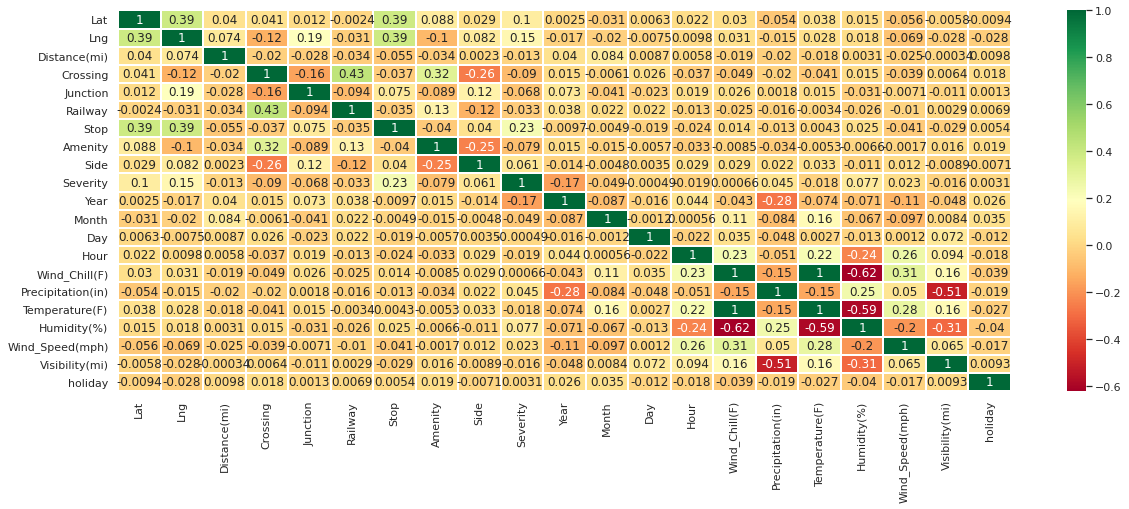

In [2]:
#Analyzing the features
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20, 7))
corr=my_df.corr()
sns.heatmap(corr, cmap ='RdYlGn', linewidths = 0.30, annot = True)


In [3]:
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

dfTestTimestampDt = pd.to_datetime(test_df['timestamp']).dt
test_df['Year'] = dfTestTimestampDt.year
test_df['Month'] = dfTestTimestampDt.month
test_df['Day'] = dfTestTimestampDt.day
test_df['Hour'] = dfTestTimestampDt.hour

test_df = pd.merge(left = test_df, right = weather, how = 'left',
              left_on=['Year', 'Month', 'Day', 'Hour'], 
              right_on=['Year', 'Month', 'Day', 'Hour'])

test_df['holiday'] = 0
for i, row in test_df.iterrows():
    if row.timestamp.split(' ')[0] in holidays:
        test_df.at[i, 'holiday'] = 1

bool_feartures = ['Crossing', 'Junction', 'Railway', 'Stop', 'Amenity']
for feat in bool_feartures:
    test_df[feat] = np.where(True == test_df[feat], 1, 0)
test_df['Side'] = np.where('R' == test_df['Side'], 1, 0)

# test_df = test_df[~test_df.Weather_Condition.isna()]
test_df['Weather_Condition'] = WeatherConditionTransformer.transform(test_df.loc[:,'Weather_Condition'])

drop_columns=['ID', 'Bump', 'Give_Way', 'No_Exit', 'Selected',
              'timestamp', 'Day','Month', 'Hour', 'Roundabout',
              'Wind_Speed(mph)', 'Distance(mi)','Junction',
              'Railway','Amenity','Wind_Chill(F)', 'Precipitation(in)','Temperature(F)',
              'Visibility(mi)', 'holiday',
             ]
X_test = test_df.drop(columns=drop_columns)

X_test.fillna(df.mean(), inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [4]:
argmax = lambda y: max(range(len(y)), key=lambda x:y[x])
classifier = models['model'][argmax(models['acc'])]

y_test_predicted = classifier.predict(X_test)

test_df['Severity'] = y_test_predicted

test_df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Weather_Condition,Wind_Chill(F),Precipitation(in),Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Selected,holiday,Severity
0,6407,37.786060,-122.390900,False,0.039,0,False,1,False,0,...,17,NaN,NaN,63.0,60.0,10.4,10.0,No,0,2
1,6408,37.769609,-122.415057,False,0.202,0,False,0,False,0,...,3,65.0,0.0,65.0,56.0,5.0,9.0,No,0,2
2,6409,37.807495,-122.476021,False,0.000,0,False,0,False,0,...,14,58.0,0.0,58.0,90.0,18.0,10.0,No,0,2
3,6410,37.761818,-122.405869,False,0.000,0,False,1,False,0,...,3,72.0,0.0,72.0,59.0,17.0,10.0,No,0,2
4,6411,37.732350,-122.414100,False,0.670,0,False,0,False,0,...,22,NaN,NaN,57.0,77.0,5.8,10.0,No,0,2


In [5]:
test_df[['ID', 'Severity']].to_csv('/kaggle/working/submission.csv', index=False)